# Data preprocessing
1. balance the dataset (optional)
2. encode category features
3. encode text features
4. modify the dataset: add 'duration', drop colunms as 'name', 'project_id', etc.
5. split dataset to training, dev and test set (90%, 5%, 5%)

In [49]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn import linear_model, datasets
from sklearn.metrics import accuracy_score
from sklearn import naive_bayes
import json
import random
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Merge, Concatenate
from keras.layers import regularizers
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
# pd.set_option('colwidth', -1)


In [4]:
# count the number of successful projects and failed projects
succ_num = sum(df['final_status'] == 1)
print(succ_num)
total_num = df.shape[0]
print(total_num)
print(1- succ_num/total_num)

34561
108129
0.6803725180108944


In [5]:
# Make the dataset balance: half successful projects and half failed projects
def balance(df):
    # seperate successful projects and failed projects
    df_succ = df[df['final_status'] == 1]
    df_fail = df[df['final_status'] == 0]
    # duplicate successful projects
    df_succ_copy = df_succ.copy()
    # random select failed projects and its amount equals to 2 times of sucessful projects
    df_fail_sel = df_fail.sample(n = succ_num*2)
    # concat the 3 dataframes
    df_balance = pd.concat([df_succ, df_succ_copy, df_fail_sel], axis=0)
    # shuffle the concated dataframe
    df_balance = shuffle(df_balance)
    return df_balance

In [6]:
# Encode 'category' features, label them with values between 0 and n_classes-1
def encoder_cat(df, col):
    le = preprocessing.LabelEncoder()
    col_label = le.fit_transform(df[col])
    df[col]=pd.Series(col_label)
    return le

In [7]:
# encode text features
def encoder_text(df, col, min_df=10):
    df[col] = df[col].astype(str)
    vectorizer = CountVectorizer(min_df=min_df)
    vectorizer.fit(df[col])
    col_bag_of_words = vectorizer.transform(df[col])
    return col_bag_of_words, vectorizer

In [8]:
def modify(df):
    # add a new colunm ‘duration’
    df.insert(13, 'duration', df['deadline']-df['launched_at'])
    # df['duration'] = df['deadline'] - df['launched_at'] 
    # drop unused colunms
    df = df.drop(columns=['Unnamed: 0', 'project_id', 'name', 'desc', 'keywords', 'deadline', 'state_changed_at', 'created_at', 'launched_at', #'backers_count', 
                          'final_status'])
    encoder_cat(df, 'country')
    encoder_cat(df, 'currency')
    encoder_cat(df, 'disable_communication')
    return df

In [9]:
def split(df):
    n = float(len(df_data))
    n_train = int(n * 0.9)
    n_dev = int(n * 0.05)
    
    train_set = df[:n_train]
    dev_set = df[n_train : (n_train + n_dev)]
    test_set = df[(n_train + n_dev) :]
    return train_set, dev_set, test_set

In [10]:
### normalize the numerical features
df_data = modify(df)

train_data, dev_data, test_data = split(df_data)

scaler = sklearn.preprocessing.StandardScaler().fit(train_data)
norm_train_data = scaler.transform(train_data)
norm_dev_data = scaler.transform(dev_data)
norm_test_data = scaler.transform(test_data)

In [12]:
### split label
n_train = train_data.shape[0]
n_dev = dev_data.shape[0]
n_test = test_data.shape[0]

labels = df['final_status']

train_label = labels[:n_train]
dev_label = labels[n_train:n_train+n_dev]
test_label = labels[n_train+n_dev:n_train+n_dev+n_test]

In [13]:
test_label.shape

(5407,)

In [14]:
test_data.shape

(5407, 6)

In [54]:
# embedding text features
def embedding_text(df, col, MAXLEN, MAX_WORDS=5000):
    df[col] = df[col].astype(str)
    tok = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
    tok.fit_on_texts(df[col])
    
    tok.word_index = {e:i for e,i in tok.word_index.items() if i <= MAX_WORDS}
    tok.word_index[tok.oov_token] = MAX_WORDS + 1

    seq = tok.texts_to_sequences(df[col])

    padded = pad_sequences(seq, maxlen=MAXLEN, padding='post')
    return (padded, tok)

In [55]:
padded_desc, desc_tok = embedding_text(df, 'desc', 30, MAX_WORDS=5000)

In [56]:
padded_kw, kw_tok = embedding_text(df, 'keywords', 10, MAX_WORDS=5000)

In [21]:
### split text features
train_desc = padded_desc[:n_train]
dev_desc = padded_desc[n_train:n_train+n_dev]
test_desc = padded_desc[n_train+n_dev:n_train+n_dev+n_test]

train_kw = padded_kw[:n_train]
dev_kw = padded_kw[n_train:n_train+n_dev]
test_kw = padded_kw[n_train+n_dev:n_train+n_dev+n_test]

# Error Analysis for Deep Neural Network Model
1. load the best model
2. randomly sample 100 errors on dev set to define the error types
3. plot the confusion matrix on test set

In [22]:
# load json and create model
json_file = open('/home/ubuntu/Notebooks/model_19.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/home/ubuntu/Notebooks/model_19_weights.hdf5")
print("Loaded model from disk")
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [23]:
loaded_model.evaluate([dev_desc, dev_kw, norm_dev_data[:, :5]], dev_label, verbose=1)

5406/5406 [==============================] - 8s 2ms/step


[0.5481614762220478, 0.7241953386230201]

In [24]:
proba = loaded_model.predict([dev_desc, dev_kw, norm_dev_data[:, :5]])

In [25]:
predictions = proba > 0.5
predictions = predictions.transpose()[0]
dev_l = np.array(dev_label > 0.5)

['A new feature documentary about the lives of cats (and their caretakers) that inhabit a popular tourist landmark in Buenos Aires.',
 'A space simulator and bounty-hunting game in the outer-space empires of 800 years in the future.',
 'A concert series designed to bring Classic Country music to the San Antonio entertainment scene.',
 'Kith & Kell, coming to a stage near you...   Support me to make this happen. :D',
 'Help our school share, with our students, the wonders of growing healthy, delicious food.',
 'Magdalena, unwittingly, continues to help George and the Dearg-due unleash supernatural forces that threaten to destroy Prague.',
 'Putting those gorgeous bottle tops to use, fashioning them into unique and personal stemmed glassware.  The Kinkajou up-cycles again.',
 'On Feb 9th 2013 at 1:00pm the AVCO will present the 2012 Youth Concerto Competition Winners Concert at the Tarrytwon Music Hall.',
 'Help me create, release, & promote my debut album. I have created songs & need ad

In [77]:
desc = list(df['desc'])
kw = list(df['keywords'])

In [82]:
error_ids = []
for i in range(predictions.shape[0]):
    if predictions[i] != dev_l[i]:
        error_ids.append(i)

In [84]:
# random.shuffle(error_ids)

for i in error_ids[:100]:
    print('*' * 50)
    print('desc: {}'.format(desc[i+n_train]))
    print('kw: {}'.format(kw[i+n_train]))
    print('prediction: {}'.format(predictions[i]))
    print('proba: {}'.format(proba[i]))
    print('gold: {}\n'.format(dev_l[i]))

**************************************************
desc: We've pushed ourselves creatively and spiritually for this album. You'll hear a matured Price Hill, but with the same focus. Worship.
kw: new-price-hill-album-recorded-by-the-digital-age
prediction: False
proba: [0.26128578]
gold: True

**************************************************
desc: The Bill Hearne Trio is gearing up to record their latest album featuring unreleased songs sure to get your toes tapping.
kw: the-bill-hearne-trios-new-album
prediction: True
proba: [0.59804255]
gold: False

**************************************************
desc: An extraordinary, punchy and provocative new play, providing a voice for women to address their sexuality and self worth. #EDFREAK
kw: get-freak-to-the-edinburgh-fringe
prediction: True
proba: [0.5015012]
gold: False

**************************************************
desc: ShutterEaze makes it easy for anyone to add remote control functionality and automate their existing interior

# Plot confusion matrix on test set

In [85]:
loaded_model.evaluate([test_desc, test_kw, norm_test_data[:, :5]], test_label, verbose=1)

5407/5407 [==============================] - 8s 1ms/step


[0.5351157423218363, 0.7277603105870813]

In [86]:
test_proba = loaded_model.predict([test_desc, test_kw, norm_test_data[:, :5]])

In [37]:
test_pred = test_proba >= 0.5
test_pred = test_pred.transpose()[0]
test_l = np.array(test_label > 0.5)

In [38]:
test_pred.shape

(5407,)

In [39]:
test_l.shape

(5407,)

In [40]:
confusion_matrix(test_l, test_pred)

array([[3324,  383],
       [1089,  611]])

In [41]:
cm = confusion_matrix(test_l, test_pred)

In [50]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.OrRd):  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  
    plt.title(title)  
    plt.colorbar()  
    xlocations = np.array([1,0])  
    plt.xticks(xlocations, labels)  
    plt.yticks(xlocations, labels, rotation=90) 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="black")
        
    plt.ylabel('True label')  
    plt.xlabel('Predicted label')  

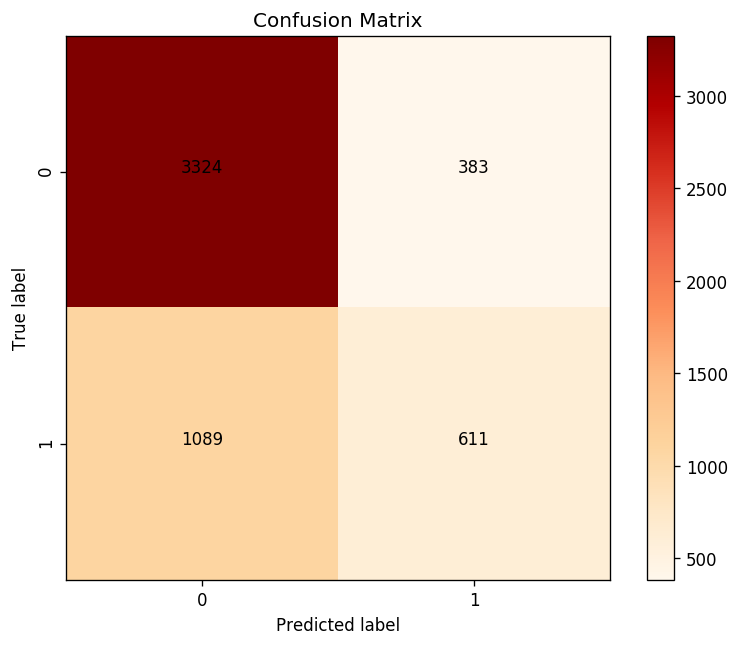

In [51]:
plt.figure(figsize=(8,6), dpi=120)
plot_confusion_matrix(cm, title='Confusion Matrix')  
#show confusion matrix 
plt.savefig('/home/ubuntu/Notebooks/images/confusion_matrix')
plt.show()  

# Our Demo
Please input your project description, keywords and goal (how much money you want to raise), then see our prediction!
Have fun! 

In [59]:
def will_i_success(desc, kw, goal):
    norm_demo_data = np.zeros([1, 6])
    norm_demo_data[0, 0] = goal
    norm_demo_data[0, 1] = 0
    norm_demo_data[0, 2] = 10
    norm_demo_data[0, 3] = 8
    norm_demo_data[0, 4] = 3600 * 24 * 30
    norm_demo_data = scaler.transform(norm_demo_data)

    demo_desc = desc_tok.texts_to_sequences([desc])
    padded_desc = pad_sequences(demo_desc, maxlen=30, padding='post')
    demo_kw = desc_tok.texts_to_sequences([kw])
    padded_kw = pad_sequences(demo_kw, maxlen=10, padding='post')

    proba = loaded_model.predict([padded_desc, padded_kw, norm_demo_data[:, :5]])[0,0]
    print('probability of success: {0:.4g}%'.format(proba*100))
    if proba > 0.5:
        print('You should totally do it!')
    else:
        print('Maybe you should consider something else...')
    
# loaded_model.predict([dev_desc, dev_kw, norm_dev_data[:, :5]], verbose=1)

In [60]:
# Example
desc = 'A new feature documentary about the lives of cats (and their caretakers) that inhabit a popular tourist landmark in Buenos Aires.'
kw = 'the guardians of recoleta'
goal = 15000
will_i_success(desc, kw, goal)

probability of success: 72.34%
You should totally do it!


In [88]:
# Example
desc = 'A cool card game of a war between raccoon and alpacas.'
kw = 'the adventure of rap raccoon and awesome alpaca'
goal = 15000
will_i_success(desc, kw, goal)

probability of success: 90.44%
You should totally do it!


In [89]:
# Example
desc = 'A mobile dating app for raccoons.'
kw = 'tinder for raccoons'
goal = 300
will_i_success(desc, kw, goal)

probability of success: 5.584%
Maybe you should consider something else...


In [90]:
# Example
desc = 'I want to shoot a documentary of a raccoon falling in love with an alpaca.'
kw = 'the love story of a raccoon'
goal = 1000
will_i_success(desc, kw, goal)

probability of success: 21.45%
Maybe you should consider something else...


In [91]:
# Example
desc = 'Homemade is a feature length documentary about a Force Recon Marine and his family after he returns from combat with hidden wounds.'
kw = 'homemade'
goal = 28000
will_i_success(desc, kw, goal)

probability of success: 59.79%
You should totally do it!


In [92]:
# Example
desc = 'We are creating a new entry luxury accessories brand for young people to enjoy better life without using spending much money.'
kw = 'entry luxury accessories for young people'
goal = 1000
will_i_success(desc, kw, goal)

probability of success: 11%
Maybe you should consider something else...
